In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

from scipy.sparse import csc_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

### 1.1 - Movielens full - EDA

### a)

In [86]:
movies_df = pd.read_csv('Data/movies.csv')
ratings_df = pd.read_csv('Data/ratings.csv', usecols=['userId', 'movieId', 'rating']) # Desperate attempts

In [87]:
display(movies_df.head(), ratings_df.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [88]:
display(
    movies_df.info(),
    ratings_df.info(),
    movies_df.describe().T,
    ratings_df.describe().T
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 635.2 MB


None

None

,count,mean,std,min,25%,50%,75%,max
movieId,58098.0,111919.516197,59862.660956,1.0,72437.75,126549.0,161449.5,193886.0


,count,mean,std,min,25%,50%,75%,max
userId,27753444.0,141942.015571,81707.400091,1.0,71176.0,142022.0,212459.0,283228.0
movieId,27753444.0,18487.999834,35102.625247,1.0,1097.0,2716.0,7150.0,193886.0
rating,27753444.0,3.530445,1.066353,0.5,3.0,3.5,4.0,5.0


### b)

In [89]:
# Groupby movieId and get the size of each list
movies_num_ratings = ratings_df.groupby(['movieId']).size()

movies_num_ratings = movies_num_ratings.sort_values(ascending=False)

# Take the index (e.g movieId) of the first 10
top_10_ratings_movieId = movies_num_ratings[:10].index

# Manually pull out single movies (e.g dataframes with one row) in order maintain the correct order as
# no indicators exist for how to sort the list. Explicitly not using isin() because it returns a dataframe
# thats already sorted by index. i spent wayyy to long on this...
top_10_most_rated = [movies_df.loc[movies_df['movieId'] == i] for i in top_10_ratings_movieId]

# concatenate all the individual dataframes into one. Meow!
top_10_most_rated = pd.concat(top_10_most_rated)

top_10_most_rated

C:\Users\Kevin\AppData\Local\Temp\ipykernel_7480\1834840940.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_10_ratings_movieId = movies_num_ratings[:10].index


,movieId,title,genres
315,318,"Shawshank Redemption, The (1994)",Crime|Drama
352,356,Forrest Gump (1994),Comedy|Drama|Romance|War
293,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
587,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
2487,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
523,527,Schindler's List (1993),Drama|War
108,110,Braveheart (1995),Action|Drama|War
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### c)

In [90]:
avr_ratings = ratings_df.groupby(['movieId'])['rating'].mean()

top_10_most_rated['average rating'] = avr_ratings[top_10_ratings_movieId].values
top_10_most_rated

,movieId,title,genres,average rating
315,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.424188
352,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.056585
293,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.173971
587,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.151412
2487,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.149695
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.120455
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.665034
523,527,Schindler's List (1993),Drama|War,4.257502
108,110,Braveheart (1995),Action|Drama|War,4.008481
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.886649


### d) - i give in... for now...

In [91]:
# pat = '|'.join(['2010'])
# s = movies_df['title'].str.extract('('+ pat + ')', expand=False)
# df1 = movies_df.groupby(s).value_counts()
# df1

test = pd.DataFrame(movies_df['title'].str[-5:-1])

f = test.groupby('title').size()
f

title
 201    2
 Ala    1
 Bab    1
 Bac    1
 Cag    2
       ..
łośc    1
σάνη    1
вани    1
льни    1
م پد    1
Length: 494, dtype: int64

### e)

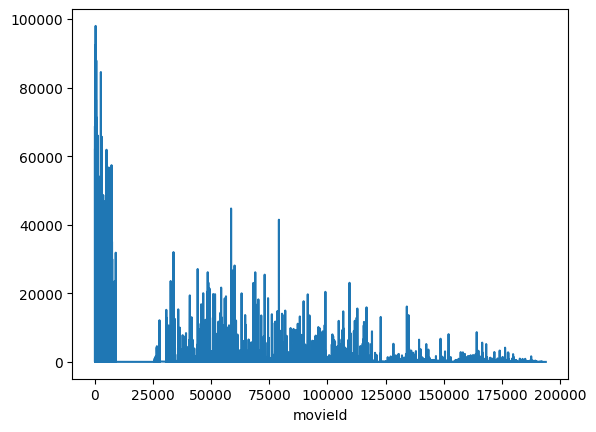

In [92]:
sns.lineplot(x=movies_num_ratings.index, y=movies_num_ratings);

### f)

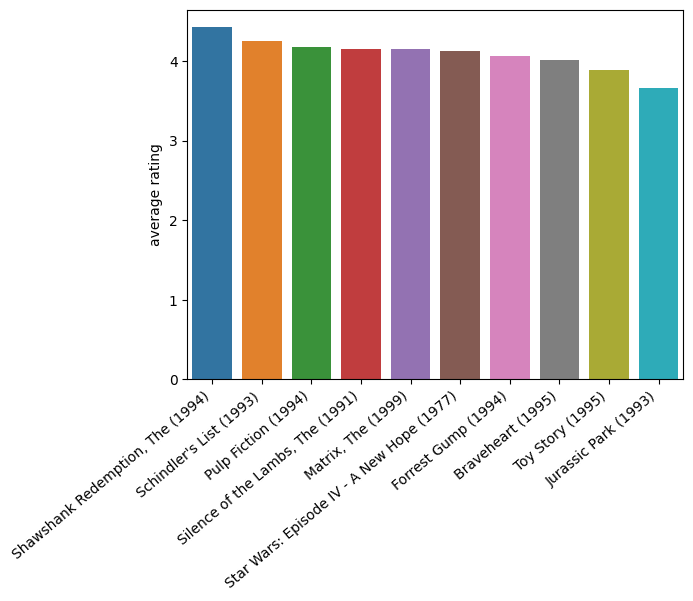

In [93]:
fig = sns.barplot(
    data=top_10_most_rated.sort_values('average rating', ascending=False),
    x='title',
    y='average rating'
)

fig.set_xticklabels(fig.get_xticklabels(), rotation=40, horizontalalignment='right');
fig.set(xlabel=None);

### 1.2

##### Drop users with >200 ratings as having that many ratings is simply unresonable and could lead<br> to a bias in the dataset.

In [94]:
# groupby user to see how many ratings each user has
num_ratings_user = ratings_df.groupby('userId').size()

# get the userId (e.g index) of users with above 200 ratings
users_high_ratings = num_ratings_user[num_ratings_user > 200].index

ratings_df = ratings_df.drop(ratings_df[ratings_df['userId'].isin(users_high_ratings)].index)

# now only about 10 million ratings left
print(f'new size {len(ratings_df)}')

new size 10801553


##### Drop movies older than the 1960's

In [95]:
movies_df_with_years = movies_df.copy()

movies_df_with_years['year'] = movies_df['title'].str.extract("\((\d{4})\)", expand=False)

movies_df_with_years['year'] = pd.to_numeric(movies_df_with_years['year'])

movies_df_with_years = movies_df_with_years[movies_df_with_years['year'] < 1960]

ratings_df = ratings_df.drop(ratings_df[ratings_df['movieId'].isin(movies_df_with_years['movieId'])].index)

print(f'new size {len(ratings_df)}')

new size 10415273


##### Drop 90% of all ratings in order to be able to actually process the data. Note that this shouldn't actually affect the quality of the dataset nor the predictions in any significant way due to the stochastic selection of rows to drop. This can roughly be seen by looking at a few key metrics.

In [96]:
ratings_mean = ratings_df['rating'].mean()
ratings_median = ratings_df['rating'].median()
ratings_std = ratings_df['rating'].std()

movie_ratings_mean = ratings_df.groupby('movieId')['rating'].mean().head()
movie_ratings_median = ratings_df.groupby('movieId')['rating'].median().head()
movie_ratings_std = ratings_df.groupby('movieId')['rating'].std().head()

print(f"{ratings_mean=} {ratings_median=} {ratings_std=}")
print(movie_ratings_mean.head(3), movie_ratings_median.head(3), movie_ratings_std.head(3))

ratings_mean=3.676744863048717 ratings_median=4.0 ratings_std=1.0724518453337943
movieId
1    3.909268
2    3.416097
3    3.281879
Name: rating, dtype: float64 movieId
1    4.0
2    3.0
3    3.0
Name: rating, dtype: float64 movieId
1    0.946496
2    0.965844
3    1.004947
Name: rating, dtype: float64


In [97]:
drop_index = ratings_df.sample(frac=0.99, replace=False).index
ratings_df = ratings_df.drop(drop_index)

In [98]:
ratings_mean = ratings_df['rating'].mean()
ratings_median = ratings_df['rating'].median()
ratings_std = ratings_df['rating'].std()

movie_ratings_mean = ratings_df.groupby('movieId')['rating'].mean().head()
movie_ratings_median = ratings_df.groupby('movieId')['rating'].median().head()
movie_ratings_std = ratings_df.groupby('movieId')['rating'].std().head()

print(f"{ratings_mean=} {ratings_median=} {ratings_std=}")
print(movie_ratings_mean.head(3), movie_ratings_median.head(3), movie_ratings_std.head(3))

ratings_mean=3.683590487071904 ratings_median=4.0 ratings_std=1.067012679528678
movieId
1    3.941975
2    3.476510
3    3.338583
Name: rating, dtype: float64 movieId
1    4.0
2    3.5
3    3.0
Name: rating, dtype: float64 movieId
1    1.001096
2    0.889761
3    1.009640
Name: rating, dtype: float64


In [120]:
#test = ratings_df.iloc[:200]

In [123]:
from scipy.sparse import csr_matrix
movies_users = ratings_df.pivot(index='movieId', columns='userId', values='rating').fillna(0)

mat_movies_users=csr_matrix(movies_users.values)

mat_movies_users.shape

(177, 128)

### 1.3

In [113]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)

In [114]:
knn_model.fit(mat_movies_users)

#idx=process.extractOne('iron man', movies_df['title'])[2]
#idx

mat_movies_users.shape

(6550, 72494)

In [115]:
# Recommender(movie_name) => List of Movies recommended

def recommender(movie_name, data,model, n_recommendations ):
    model.fit(data)
    idx=process.extractOne(movie_name, movies_df['title'])[2]
    print('Movie Selected: ',movies_df['title'][idx], 'Index: ',idx)
    print('Searching for recommendations.....')
    distances, indices=model.kneighbors(data[idx], n_neighbors=n_recommendations)
    for i in indices:
        print(movies_df['title'][i].where(i!=idx))
    
recommender('iron man', mat_movies_users, knn_model,20)


Movie Selected:  Iron Man (2008) Index:  12666
Searching for recommendations.....


IndexError: row index (12666) out of range